In [1]:
import numpy as np
import cv2
import os
import glob
import matplotlib.pyplot as plt
import json


In [2]:
CHESSBOARD_SIZE = (8, 6)
folder_path = 'my_images'

images = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.jpg')]

In [3]:
imgpts, objpts = [], []

objp = np.zeros((CHESSBOARD_SIZE[0] * CHESSBOARD_SIZE[1], 3), np.float32)
objp[:,:2] = np.mgrid[0:CHESSBOARD_SIZE[0],0:CHESSBOARD_SIZE[1]].T.reshape(-1,2)

In [4]:
image_size = None

for i in images:
    img = cv2.imread(i)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, CHESSBOARD_SIZE, cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)
    if ret == True:
        objpts.append(objp)
        imgpts.append(corners)
        img = cv2.drawChessboardCorners(img, CHESSBOARD_SIZE, corners, ret)
    
    image_size = gray.shape[::-1]

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpts, imgpts, image_size, None, None)

3a

In [5]:
print("Intrinsic Camera Matrix:")
print(mtx)

print("Focal Lengths:")
print(mtx[0,0], mtx[1,1])

print("Skew Parameter:")
print(mtx[0,1])

print("Principal Point:")
print(mtx[0,2], mtx[1,2])

Intrinsic Camera Matrix:
[[3.15392746e+03 0.00000000e+00 1.11333065e+03]
 [0.00000000e+00 3.14796429e+03 1.87052901e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Focal Lengths:
3153.927457499056 3147.9642924899895
Skew Parameter:
0.0
Principal Point:
1113.3306464801728 1870.5290098523756


3b

In [6]:
rotation_matrices = []

for i in rvecs:
    matrix = cv2.Rodrigues(i)[0]
    rotation_matrices.append(matrix)

In [7]:
print("-" * 10, "First Image", "-" * 10)
print("Rotation Matrix:")
print(rotation_matrices[0])
print("Translation Vectors:")
print(tvecs[0])

print("-" * 10, "Second Image", "-" * 10)
print("Rotation Matrix:")
print(rotation_matrices[1])
print("Translation Vectors:")
print(tvecs[1])

---------- First Image ----------
Rotation Matrix:
[[ 3.32065119e-04 -9.57223527e-01 -2.89349284e-01]
 [ 9.99526900e-01 -8.58120760e-03  2.95353827e-02]
 [-3.07549294e-02 -2.89222201e-01  9.56767816e-01]]
Translation Vectors:
[[ 2.48771718]
 [-3.62785088]
 [16.20459226]]
---------- Second Image ----------
Rotation Matrix:
[[ 0.65200992 -0.61537277 -0.44294404]
 [ 0.68745579  0.72622     0.00300711]
 [ 0.31982433 -0.30646511  0.89654422]]
Translation Vectors:
[[ 0.49735577]
 [-3.01215934]
 [16.82658625]]


3c

In [8]:
print("Radial Distortion Coefficients:")
print(dist[0][0], dist[0][1], dist[0][4])

Radial Distortion Coefficients:
0.125991394128843 -1.236618736915827 1.1006754269664025


In [9]:
def board_corners(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, CHESSBOARD_SIZE, cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)
    if ret == True:
        return True, corners
    return False, None

In [10]:
radial_dist = dist.copy()
radial_dist[0][2] = 0
radial_dist[0][3] = 0

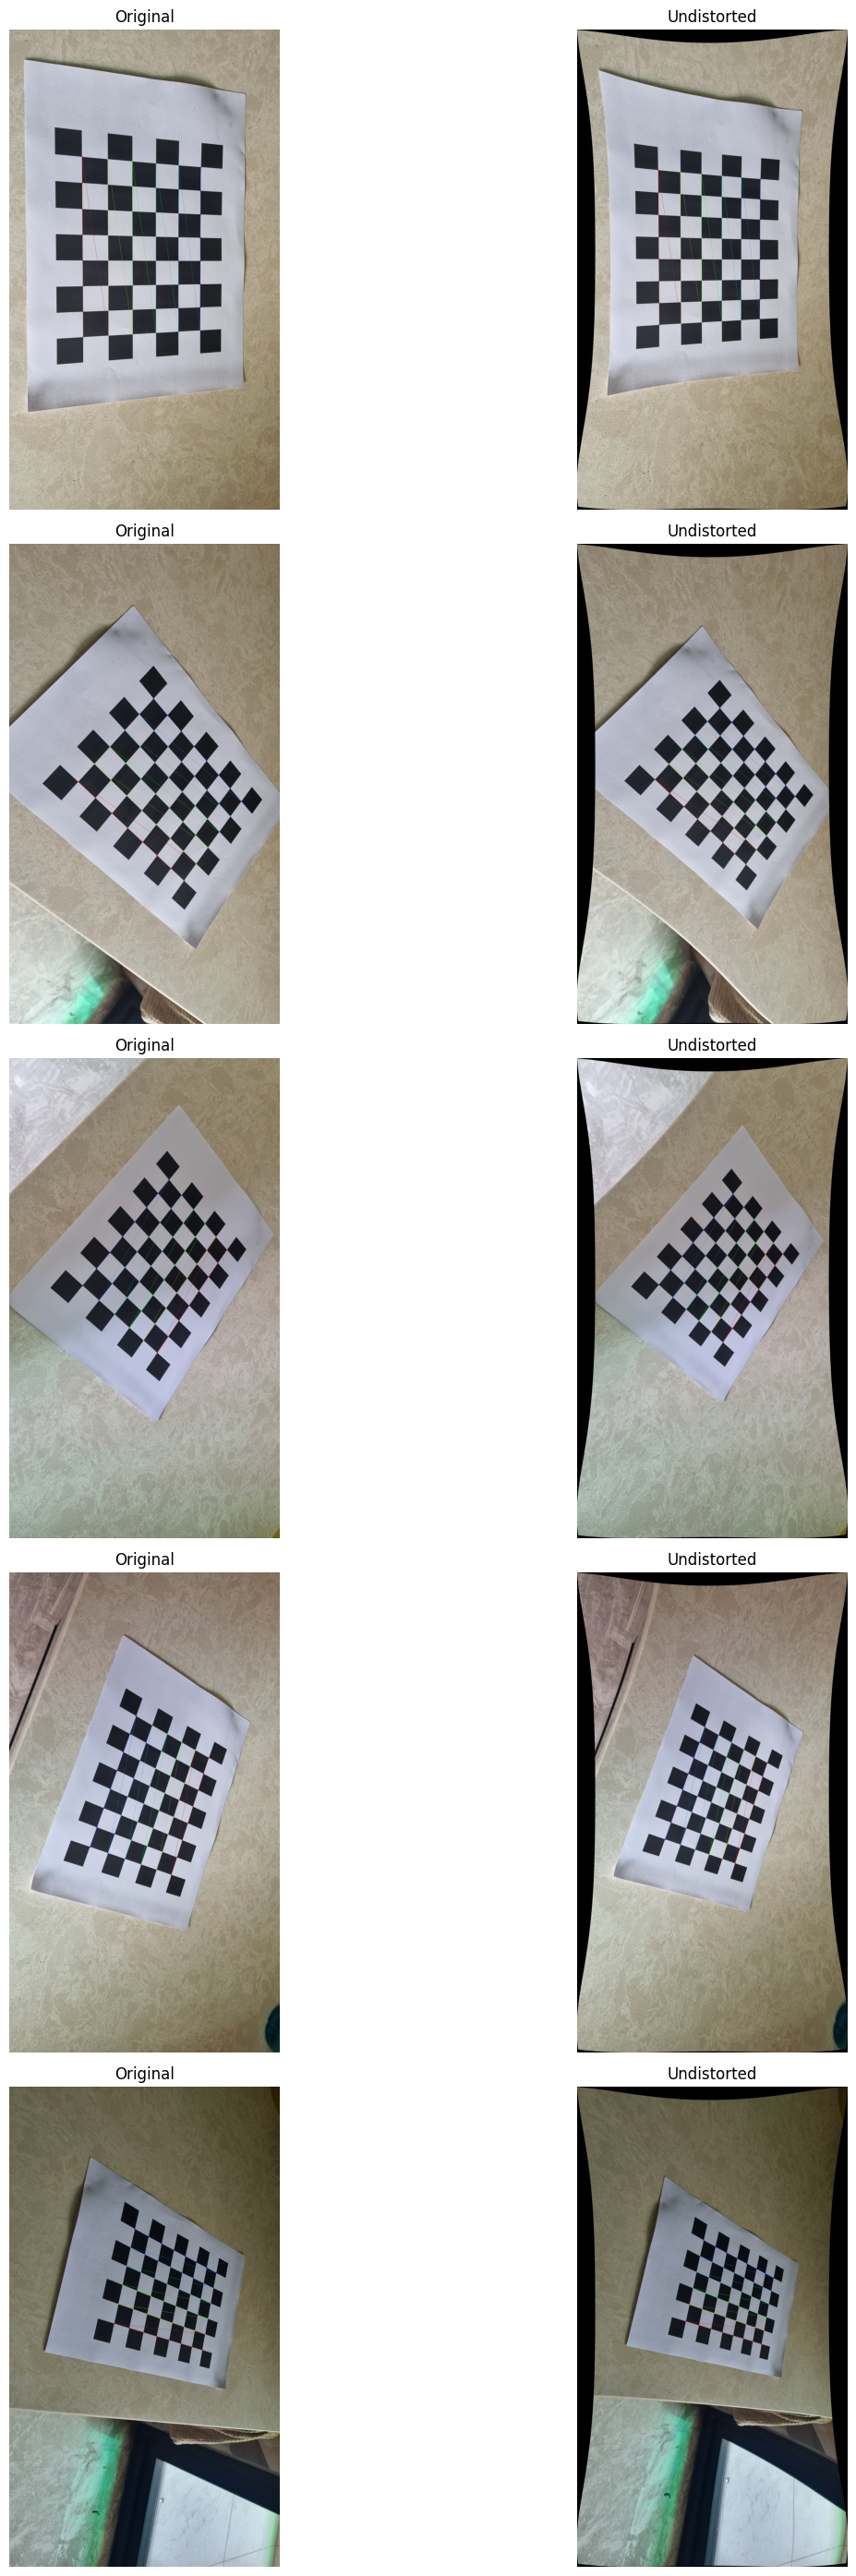

In [11]:
plt.figure(figsize=(16, 28))

for i, img_path in enumerate(images[:5]):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    h, w = img.shape[:2]
    new_mtx, roi = cv2.getOptimalNewCameraMatrix(mtx, radial_dist, (w, h), 1, (w, h))
    undistorted = cv2.undistort(img, mtx, radial_dist, None, new_mtx)
    
    ret, corners = board_corners(img)
    ret_undistorted, corners_undistorted = board_corners(undistorted)

    if ret:
        img = cv2.drawChessboardCorners(img, CHESSBOARD_SIZE, corners, ret)
    if ret_undistorted:
        undistorted = cv2.drawChessboardCorners(undistorted, CHESSBOARD_SIZE, corners_undistorted, ret_undistorted)

    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(img)
    plt.title(f"Original")
    plt.axis('off')

    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(undistorted)
    plt.title(f"Undistorted")
    plt.axis('off')

plt.tight_layout()

3d

In [12]:
errors = []

for i in range(len(objpts)):
    imgpts_proj, _ = cv2.projectPoints(objpts[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv2.norm(imgpts[i], imgpts_proj, cv2.NORM_L2) / len(imgpts_proj)
    errors.append(error)

print(f"Average Reprojection Error: {np.mean(errors)}")
print(f"Standard Deviation of Reprojection Error: {np.std(errors)}")


Average Reprojection Error: 0.24485286161517938
Standard Deviation of Reprojection Error: 0.18316229263055397


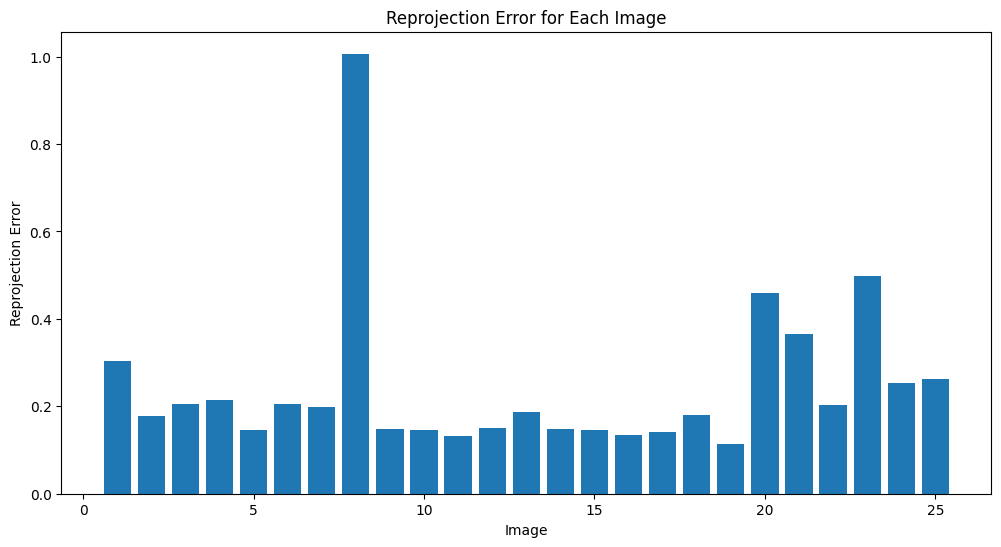

In [13]:
plt.figure(figsize=(12, 6))
plt.bar(range(1, len(errors) + 1), errors)
plt.xlabel('Image')
plt.ylabel('Reprojection Error')
plt.title('Reprojection Error for Each Image')
plt.show()


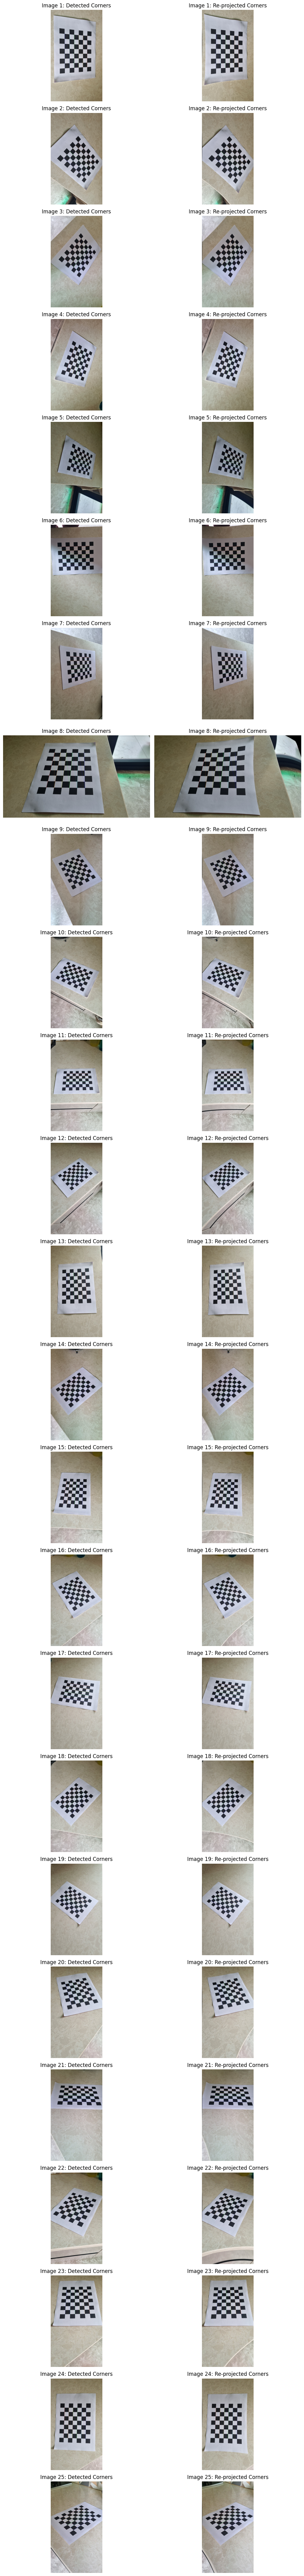

In [14]:
plt.figure(figsize=(10, 84))

for i in range(len(objpts)):
    img = cv2.imread(images[i])

    undistorted = cv2.undistort(img, mtx, dist)
    
    reprojected_corners, _ = cv2.projectPoints(objpts[i], rvecs[i], tvecs[i], mtx, dist)

    img_detected = img.copy()
    corners_reshaped = imgpts[i].reshape(-1, 1, 2).astype(np.float32)
    cv2.drawChessboardCorners(img_detected, CHESSBOARD_SIZE, corners_reshaped, True)

    img_reprojected = undistorted.copy()
    reprojected_corners_reshaped = reprojected_corners.reshape(-1, 1, 2).astype(np.float32)
    cv2.drawChessboardCorners(img_reprojected, CHESSBOARD_SIZE, reprojected_corners_reshaped, True)

    img_detected_rgb = cv2.cvtColor(img_detected, cv2.COLOR_BGR2RGB)
    img_reprojected_rgb = cv2.cvtColor(img_reprojected, cv2.COLOR_BGR2RGB)

    plt.subplot(25, 2, 2*i + 1)
    plt.imshow(img_detected_rgb)
    plt.title(f"Image {i+1}: Detected Corners")
    plt.axis('off')

    plt.subplot(25, 2, 2*i + 2)
    plt.imshow(img_reprojected_rgb)
    plt.title(f"Image {i+1}: Re-projected Corners")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [15]:
normals = []
for idx, i in enumerate(rotation_matrices):
    normals.append(i[2])

In [16]:
for i in range(len(normals)):
    print(f"Image {i} normal: {normals[i]}")

Image 0 normal: [-0.03075493 -0.2892222   0.95676782]
Image 1 normal: [ 0.31982433 -0.30646511  0.89654422]
Image 2 normal: [0.35927871 0.34604959 0.86669977]
Image 3 normal: [0.19895068 0.43945268 0.8759566 ]
Image 4 normal: [ 0.63289203 -0.16821464  0.75574567]
Image 5 normal: [0.00958054 0.07086298 0.99744005]
Image 6 normal: [0.67619901 0.07394018 0.73299915]
Image 7 normal: [ 0.45362482 -0.27227615  0.8485813 ]
Image 8 normal: [-0.38769005 -0.22699571  0.89340325]
Image 9 normal: [-0.24506471 -0.41946981  0.87406428]
Image 10 normal: [-0.0185347  -0.50237187  0.86445299]
Image 11 normal: [ 0.28503474 -0.37460723  0.88228375]
Image 12 normal: [-0.25421231  0.06505114  0.96495826]
Image 13 normal: [ 0.24511513 -0.37139968  0.89553384]
Image 14 normal: [ 0.43147688 -0.07228929  0.89922297]
Image 15 normal: [-0.40281155 -0.22000885  0.8884475 ]
Image 16 normal: [-0.15215614 -0.36139732  0.9199133 ]
Image 17 normal: [ 0.24101228 -0.29685035  0.92400917]
Image 18 normal: [-0.31500345 -0

In [17]:
f_x = float(mtx[0, 0]) 
f_y = float(mtx[1, 1])  
skew = float(mtx[0, 1])  
c_x = float(mtx[0, 2])
c_y = float(mtx[1, 2])

radial_k1 = float(radial_dist[0][0])
radial_k2 = float(radial_dist[0][1])
radial_k3 = float(radial_dist[0][4])

mean_reprojection = float(np.mean(errors)) 
std_dev_reprojection = float(np.std(errors)) 

extrinsic_parameters_data = [
    {
        "image_id": 1,
        "rotation_matrix": rotation_matrices[0].tolist(),  
        "translation_vector": tvecs[0].flatten().tolist()  
    },
    {
        "image_id": 2,
        "rotation_matrix": rotation_matrices[1].tolist(),  
        "translation_vector": tvecs[1].flatten().tolist()
    },
]

data = {
    "intrinsic_parameters": {
        "focal_length": [f_x, f_y],
        "skew": skew,
        "principal_point": [c_x, c_y]
    },
    "extrinsic_parameters": extrinsic_parameters_data,
    "radial_distortion_coefficients": [radial_k1, radial_k2, radial_k3],
    "reprojection_errors": {
        "mean_error": mean_reprojection,
        "std_dev": std_dev_reprojection
    }
}

json_output = json.dumps(data, indent=4)
print(json_output)

with open("my_images_params.json", "w") as f:
    json.dump(data, f, indent=4)


{
    "intrinsic_parameters": {
        "focal_length": [
            3153.927457499056,
            3147.9642924899895
        ],
        "skew": 0.0,
        "principal_point": [
            1113.3306464801728,
            1870.5290098523756
        ]
    },
    "extrinsic_parameters": [
        {
            "image_id": 1,
            "rotation_matrix": [
                [
                    0.00033206511931547014,
                    -0.9572235274851596,
                    -0.28934928401781873
                ],
                [
                    0.999526900111933,
                    -0.008581207597110507,
                    0.029535382658859383
                ],
                [
                    -0.030754929448569557,
                    -0.28922220057430426,
                    0.9567678156217266
                ]
            ],
            "translation_vector": [
                2.4877171841211405,
                -3.6278508813340853,
                16.2045922634213